In [34]:
import pandas as pd
import numpy as np
import psycopg2
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
import ast 
pd.set_option('display.max_columns', None)

In [8]:
os.getcwd() 

'c:\\Users\\ACER\\Documents\\Maestria\\Proyecto de Grado\\Repo\\audio_reprompt'

In [12]:
prompts=pd.read_csv(os.getcwd() +'\data\docs\spanio_captions_embeddings.csv')
prompts.head()

,text,embedding
0,sweet melancholic piano piece,"[-0.044995855540037155, 0.045553144067525864, ..."
1,bitter sweet dreamy piano piece,"[-0.044926997274160385, 0.04424956068396568, -..."
2,sweet salty piece continuous arpeggio short no...,"[-0.0454317182302475, 0.043483834713697433, -0..."
3,bitter piece little salty mainly introduction ...,"[-0.044952113181352615, 0.04458863288164139, -..."
4,sweet bitter static piano piece really slow tempo,"[-0.04486694931983948, 0.04254024103283882, -0..."


In [17]:
caps=pd.read_csv(rf"{os.getcwd()}\data\docs\audio_caps_embeddings.csv")
caps.head()

,text,embedding
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -..."
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0..."
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -..."
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -..."
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -..."


In [38]:
class CosineRAG:
    def __init__(self, df):
        """
        df: DataFrame con columnas ['text', 'embedding']
        """
        self.docs = df['text'].tolist()
        # Convertir las listas en texto a np.array
        self.doc_embeddings = np.vstack(df['embedding'].apply(ast.literal_eval).to_numpy())
        # Normalizar embeddings (para que cosine_similarity sea más estable)
        self.doc_embeddings = self.doc_embeddings / np.linalg.norm(self.doc_embeddings, axis=1, keepdims=True)

    def retrieve(self, query_emb, k):
        """
        Retorna los k documentos más similares a un embedding de query.
        """
        query_emb = np.array(query_emb)
        query_emb = query_emb / np.linalg.norm(query_emb)
        similarities = cosine_similarity([query_emb], self.doc_embeddings)[0]
        top_k_idx = np.argsort(similarities)[::-1][:k]
        results = [(self.docs[i], float(similarities[i])) for i in top_k_idx]
        return results


def build_rag_table(prompts_df, rag, k):
    """
    Crea un DataFrame con columnas:
    [prompt, retrieve_1, retrieve_2, ..., retrieve_k]
    
    prompts_df: DataFrame con ['text', 'embedding']
    rag: instancia de CosineRAG creada con los retrieves (caps)
    """
    data = []
    for _, row in prompts_df.iterrows():
        prompt = row['text']
        query_emb = np.array(ast.literal_eval(row['embedding']))
        retrieves = [doc for doc, _ in rag.retrieve(query_emb, k)]
        row_data = [prompt] + retrieves
        data.append(row_data)
    
    columns = ["prompt"] + [f"retrieve_{i+1}" for i in range(k)]
    return pd.DataFrame(data, columns=columns)

In [39]:
rag = CosineRAG(caps)

In [40]:
rag_df = build_rag_table(prompts, rag, k=10)
rag_df.head()

,prompt,retrieve_1,retrieve_2,retrieve_3,retrieve_4,retrieve_5,retrieve_6,retrieve_7,retrieve_8,retrieve_9,retrieve_10
0,sweet melancholic piano piece,mellow arpeggiated piano melody,classical piano piece,short accordion melody,mellow classical piano melody,mellow sustained strings melody,instrumental piece,suspenseful piano melody,classical duet,mellow piano melody,mellow arpeggiated melody
1,bitter sweet dreamy piano piece,breathy flute melody,mellow harp melody,smooth piano melody,breathy reverberant flute melody,buzzy harpsichord melody,mellow sustained strings melody,mellow arpeggiated piano melody,addictive plucked strings melody,subtle strings melody,suspenseful electric guitar melody
2,sweet salty piece continuous arpeggio short no...,guitars playing in harmony,playful accordion harmony,suspenseful synth arpeggio melody,guitar playing rhythm,complex synth arpeggio melodies,short accordion melody,addictive plucked strings melody,instrumental musical retro game track,solo low tuba melody,mellow sustained strings melody
3,bitter piece little salty mainly introduction ...,wide plucked strings melody,echoing plucked strings melody,repetitive low plucked string melody,breathy reverberant flute melody,repetitive plucked strings melody,solo low tuba melody,solo still guitar melody,mellow harmonized flute melody,echoing electric guitar arpeggiated melody,synthesized orchestral string pad
4,sweet bitter static piano piece really slow tempo,simple strings melody,mellow sustained strings melody,passionate dynamic classical piano melody,short accordion melody,high pitched sustained string melody,dark moody piano melody,mellow arpeggiated piano melody,breathy flute melody,smooth piano melody,soft piano melody


In [28]:
def build_similarity_table(prompts_df, rag, k=3):
    """
    Crea un DataFrame con columnas:
    [prompt, sim_1, sim_2, ..., sim_k]
    
    Donde cada sim_i es el valor de similitud coseno entre
    el prompt y su retrieve i-ésimo más similar.
    """
    data = []

    for _, row in prompts_df.iterrows():
        prompt = row['text']
        query_emb = np.array(ast.literal_eval(row['embedding']))
        query_emb = query_emb / np.linalg.norm(query_emb)

        # calcular similitud coseno con todos los retrieves
        similarities = cosine_similarity([query_emb], rag.doc_embeddings)[0]
        top_k_idx = np.argsort(similarities)[::-1][:k]
        top_k_scores = [float(similarities[i]) for i in top_k_idx]

        data.append([prompt] + top_k_scores)

    columns = ["prompt"] + [f"sim_{i+1}" for i in range(k)]
    return pd.DataFrame(data, columns=columns)

sim_cos=build_similarity_table(prompts, rag, k=10)

In [29]:
sim_cos['mean_per_prompt'] = sim_cos.iloc[:, 1:].mean(axis=1)

# Promedio por columna (nivel de similitud según la posición del retrieve)
mean_per_column = sim_cos.iloc[:, 1:-1].mean(axis=0)

# Mostrar resultados
print("Promedio por fila (primeras 5):")
print(sim_cos[['prompt', 'mean_per_prompt']].head())

print("\nPromedio por columna (por retrieve):")
print(mean_per_column)

Promedio por fila (primeras 5):
                                              prompt  mean_per_prompt
0                      sweet melancholic piano piece         0.999725
1                    bitter sweet dreamy piano piece         0.999642
2  sweet salty piece continuous arpeggio short no...         0.999459
3  bitter piece little salty mainly introduction ...         0.999093
4  sweet bitter static piano piece really slow tempo         0.999650

Promedio por columna (por retrieve):
sim_1     0.999540
sim_2     0.999520
sim_3     0.999509
sim_4     0.999502
sim_5     0.999496
sim_6     0.999490
sim_7     0.999485
sim_8     0.999481
sim_9     0.999478
sim_10    0.999475
dtype: float64


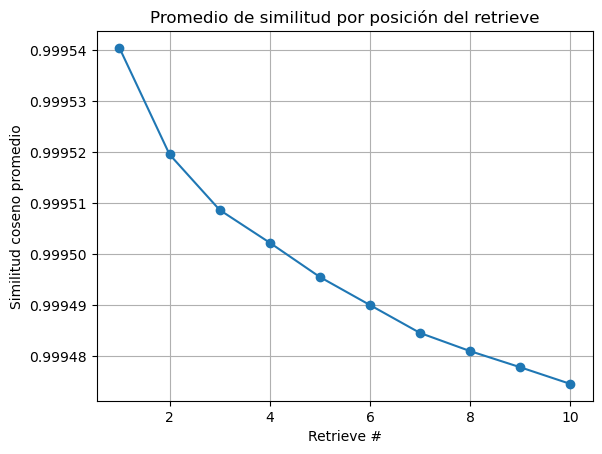

In [30]:
import matplotlib.pyplot as plt

# Promedio por posición del retrieve
plt.plot(range(1, len(mean_per_column)+1), mean_per_column.values, marker='o')
plt.title('Promedio de similitud por posición del retrieve')
plt.xlabel('Retrieve #')
plt.ylabel('Similitud coseno promedio')
plt.grid(True)
plt.show()

In [32]:
sim_cos['mean_per_prompt'].describe()

count    100.000000
mean       0.999497
std        0.000149
min        0.999093
25%        0.999393
50%        0.999533
75%        0.999598
max        0.999762
Name: mean_per_prompt, dtype: float64

In [37]:
rag_df.columns

Index(['prompt', 'retrieve_1', 'retrieve_2', 'retrieve_3'], dtype='object')